In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import torch
import torch.nn as nn
import torchsde

import sys

sys.path.append("./src")

from springs_sdes import S3DE, GS3DE, GGS3DE
from springs_plot import animate_springs, generalized_animation
from viz import evolution_plot, plot_evolution_ud_vs_od

## Time evolution for different dift coefficients at different scales

Imagine a large stick with strong springs vs. a small stick with weak springs. The 'collisions' of each atom from the environment with the stick will make the system move, and the smaller system will fluctuate more as its energy is closer to that of the kinetic energy of an individual atom. We see this effect in the time evolution of the system as we decrease $k$ and $M$.

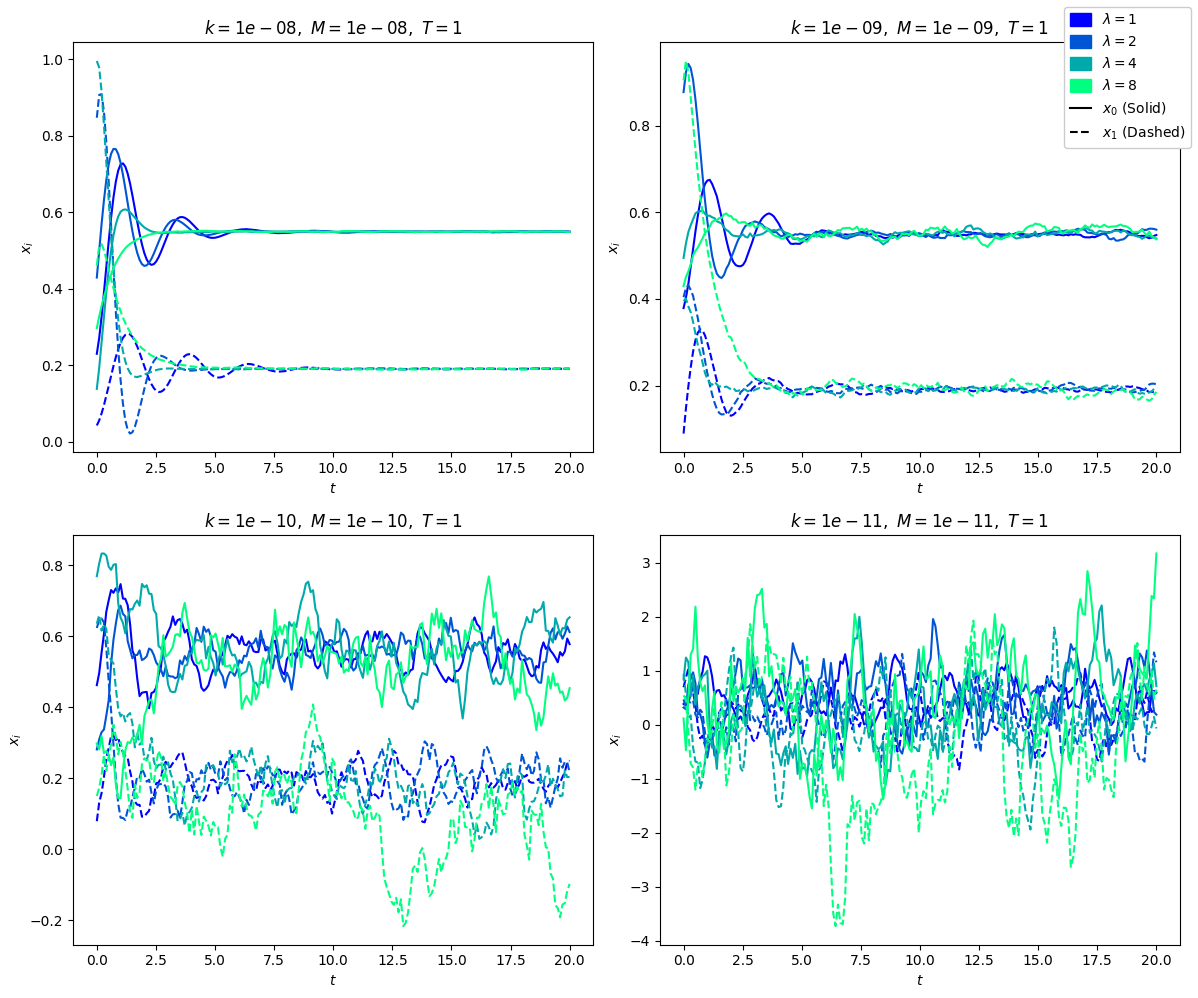

In [ ]:
batch_size, state_size, t_size = 2, 4, 200
ts = torch.linspace(0, 20, t_size)

friction_values = [1, 2, 4, 8]
colors = plt.cm.winter(np.linspace(0, 1, len(friction_values)))

k_values = [1e-8, 1e-9, 1e-10, 1e-11]
M_values = [1e-8, 1e-9, 1e-10, 1e-11]


def plot_for_different_frictions(ts, friction_values, k_values, M_values):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()

    for i, (k, M) in enumerate(zip(k_values, M_values)):
        for j, friction in enumerate(friction_values):
            y0 = torch.rand(size=(batch_size, state_size))
            sde = S3DE(u_i, y_i, friction=friction, temp=1, k=k, M=M)
            with torch.no_grad():
                ys = torchsde.sdeint(sde, y0, ts, method="euler")

            ts_cpu = ts.cpu()
            ys_cpu = ys[:, 0, :2].squeeze().t().cpu()

            axs[i].plot(ts_cpu, ys_cpu[0], color=colors[j])
            axs[i].plot(ts_cpu, ys_cpu[1], "--", color=colors[j])

        axs[i].set_xlabel("$t$")
        axs[i].set_ylabel("$x_i$")
        axs[i].set_title(rf"$k={k},\ M={M},\ T=1$")

    legend_elements = [
        mpatches.Patch(color=colors[i], label=rf"$\lambda = {friction}$")
        for i, friction in enumerate(friction_values)
    ]
    legend_elements.append(mlines.Line2D([], [], color="black", label="$x_0$ (Solid)"))
    legend_elements.append(
        mlines.Line2D([], [], color="black", linestyle="--", label="$x_1$ (Dashed)")
    )

    fig.legend(
        handles=legend_elements, framealpha=1.0, handlelength=1.5, handleheight=1.0
    )

    plt.tight_layout()
    plt.savefig("figs/positions_multiple_params.pdf")
    plt.show()


plot_for_different_frictions(ts, friction_values, k_values, M_values)

## How close are we to the optimal solution?

A natural question is, can we actually use the small system to do a linear regression? How do the fluctuations affect the inference? Naturally, we consider the system when it has reached a steady state ($t\to\infty$) to perform inference.

In [ ]:
from sklearn.linear_model import LinearRegression


def optimal_parameters(u_i, y_i):
    reg = LinearRegression().fit(u_i.reshape(-1, 1), y_i)
    return reg.coef_[0], reg.intercept_


def delta_err(param1, param2, param1_opt, param2_opt):
    return torch.abs(param1 - param1_opt), torch.abs(param2 - param2_opt)


def norm_err(param1, param2, param1_opt, param2_opt):
    delta1, delta2 = delta_err(param1, param2, param1_opt, param2_opt)
    return np.sqrt(delta1**2 + delta2**2)


def variance_err(param1, param2, param1_opt, param2_opt):
    delta1, delta2 = delta_err(param1, param2, param1_opt, param2_opt)
    return torch.var(delta1, dim=0), torch.var(delta2, dim=0)


def std_err(param1, param2, param1_opt, param2_opt):
    delta1, delta2 = delta_err(param1, param2, param1_opt, param2_opt)
    return torch.std(delta1, dim=0), torch.std(delta2, dim=0)

/Users/luismantilla/Desktop/UofT/2024-1/Projects/SpringsSticks/springs-and-sticks/./src/springs_sdes.py:99: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  x0, x1, _, _ = y.T


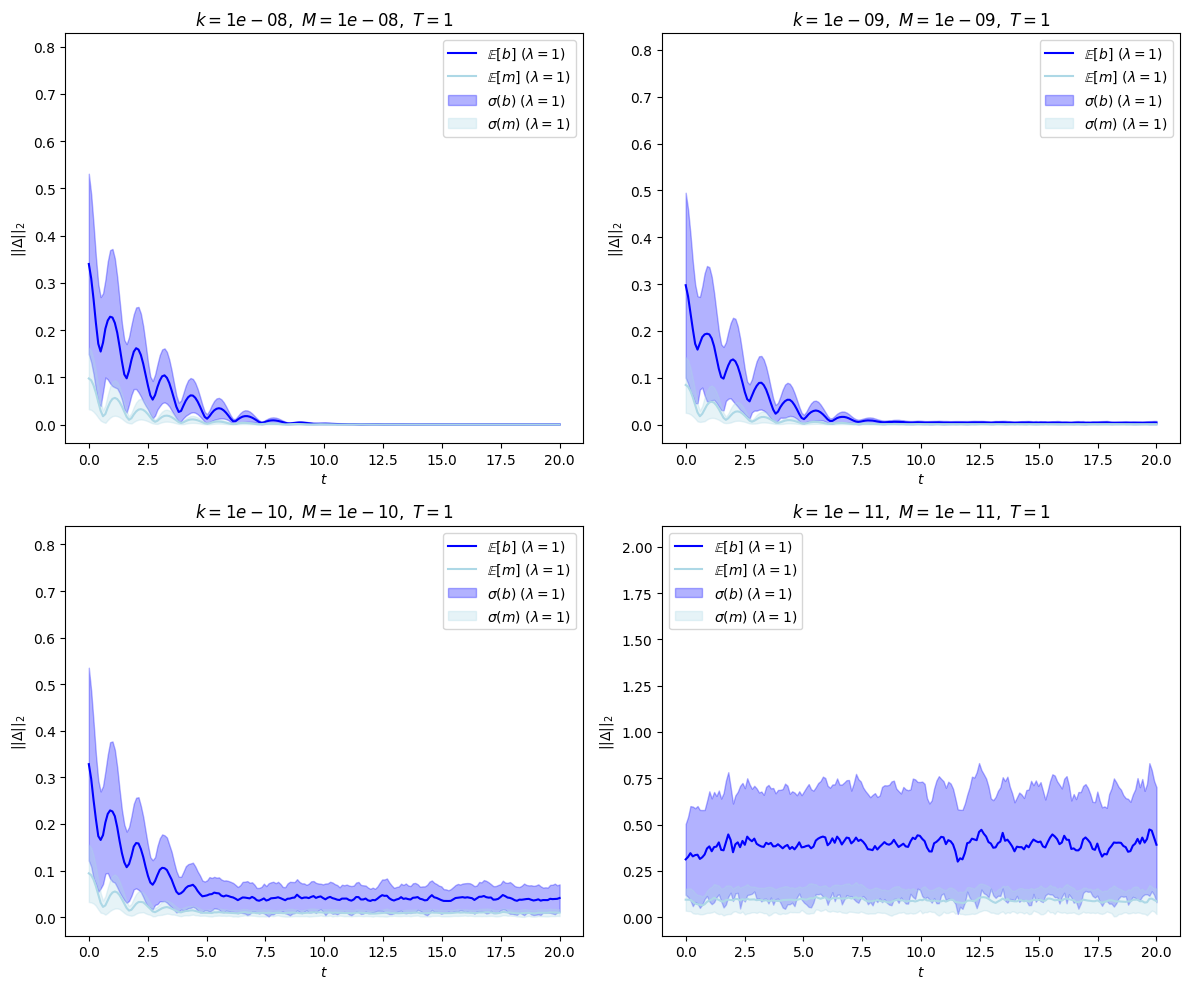

In [ ]:
batch_size, state_size, t_size = 100, 4, 200
ts = torch.linspace(0, 20, t_size)

friction_values = [1, 5, 10]
colors = plt.cm.winter(np.linspace(0, 1, len(friction_values)))

k_values = [1e-8, 1e-9, 1e-10, 1e-11]
M_values = [1e-8, 1e-9, 1e-10, 1e-11]


def error_plot_for_different_params(ts, k_values, M_values):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()

    for i, (k, M) in enumerate(zip(k_values, M_values)):
        y0 = torch.rand(size=(batch_size, state_size))
        sde = S3DE(u_i, y_i, friction=1, temp=1, k=k, M=M)
        with torch.no_grad():
            ys = torchsde.sdeint(sde, y0, ts, method="euler")

        slopes, intercepts = sde.model_params(ys)
        errors_m, errors_b = delta_err(
            slopes, intercepts, *optimal_parameters(u_i, y_i)
        )
        vars_err = variance_err(slopes, intercepts, *optimal_parameters(u_i, y_i))
        stds_err = std_err(slopes, intercepts, *optimal_parameters(u_i, y_i))

        for j in range(errors_b.shape[0]):
            axs[i].plot(ts, errors_b[j], color="black", alpha=0.001)
            axs[i].plot(ts, errors_m[j], color="darkgreen", alpha=0.001)

        axs[i].plot(
            ts,
            torch.mean(errors_b, axis=0),
            c="blue",
            label=rf"$\mathbb{{E}}[b]\ (\lambda={1})$",
        )
        axs[i].plot(
            ts,
            torch.mean(errors_m, axis=0),
            c="lightblue",
            label=rf"$\mathbb{{E}}[m]\ (\lambda={1})$",
        )
        axs[i].fill_between(
            ts,
            y1=torch.mean(errors_b, axis=0) - stds_err[1],
            y2=torch.mean(errors_b, axis=0) + stds_err[1],
            alpha=0.3,
            color="blue",
            label=rf"$\sigma(b)\ (\lambda={1})$",
        )
        axs[i].fill_between(
            ts,
            y1=torch.mean(errors_m, axis=0) - stds_err[0],
            y2=torch.mean(errors_m, axis=0) + stds_err[0],
            alpha=0.3,
            color="lightblue",
            label=rf"$\sigma(m)\  (\lambda={1})$",
        )

        axs[i].set_xlabel(r"$t$")
        axs[i].set_ylabel(r"$||\Delta||_2$")
        axs[i].set_title(rf"$k={k},\ M={M},\ T=1$")

        axs[i].legend()

    plt.tight_layout()
    plt.savefig("figs/errors_multiple_params.pdf")
    plt.show()


error_plot_for_different_params(ts, k_values, M_values)

In [ ]:
batch_size, state_size, t_size = 10, 4, 100
ts = torch.linspace(0, 20, t_size)

friction_values = [0.1, 1, 10, 100]
k_values = M_values = np.logspace(-4, -14, num=30, base=10)

errors_fric = {}
vars_fric = {}

for f, friction in enumerate(friction_values):
    errors_avg = []
    variances_avg = []
    for i, (k, M) in enumerate(zip(k_values, M_values)):
        y0 = torch.rand(size=(batch_size, state_size))
        sde = S3DE(u_i, y_i, friction=friction, temp=1, k=k, M=M)
        with torch.no_grad():
            ys = torchsde.sdeint(sde, y0, ts, method="euler")

        slopes, intercepts = sde.model_params(ys)
        errors_m, errors_b = delta_err(
            slopes, intercepts, *optimal_parameters(u_i, y_i)
        )
        vars_err = variance_err(slopes, intercepts, *optimal_parameters(u_i, y_i))
        stds_err = std_err(slopes, intercepts, *optimal_parameters(u_i, y_i))

        errors_avg.append(
            torch.sqrt(errors_m**2 + errors_b**2)[-ts.shape[0] // 4 :].mean()
        )
        variances_avg.append(
            torch.sqrt(vars_err[0] ** 2 + vars_err[1] ** 2)[-ts.shape[0] // 4 :].mean()
        )

    errors_fric[friction] = errors_avg
    vars_fric[friction] = variances_avg

In [ ]:
temp_values = [1, 10, 100, 1000]

errors_temp = {}
vars_temp = {}

for ind_t, temp in enumerate(temp_values):
    errors_avg = []
    variances_avg = []
    for i, (k, M) in enumerate(zip(k_values, M_values)):
        y0 = torch.rand(size=(batch_size, state_size))
        sde = S3DE(u_i, y_i, friction=1, temp=temp, k=k, M=M)
        with torch.no_grad():
            ys = torchsde.sdeint(sde, y0, ts, method="euler")

        slopes, intercepts = sde.model_params(ys)
        errors_m, errors_b = delta_err(
            slopes, intercepts, *optimal_parameters(u_i, y_i)
        )
        vars_err = variance_err(slopes, intercepts, *optimal_parameters(u_i, y_i))
        stds_err = std_err(slopes, intercepts, *optimal_parameters(u_i, y_i))

        errors_avg.append(
            torch.sqrt(errors_m**2 + errors_b**2)[-ts.shape[0] // 4 :].mean()
        )
        variances_avg.append(
            torch.sqrt(vars_err[0] ** 2 + vars_err[1] ** 2)[-ts.shape[0] // 4 :].mean()
        )

    errors_temp[temp] = errors_avg
    vars_temp[temp] = variances_avg

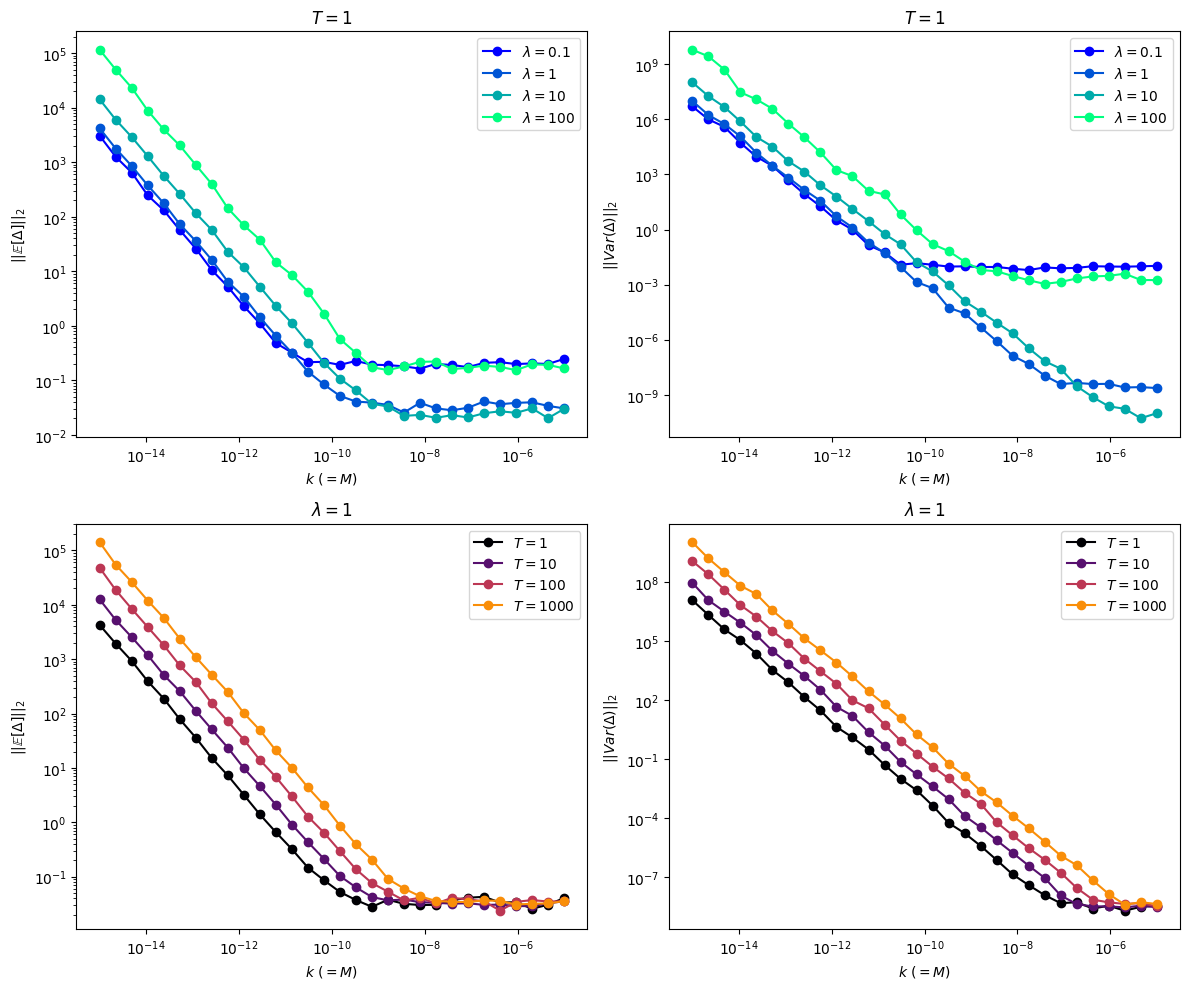

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
colors = plt.cm.winter(np.linspace(0, 1, len(friction_values)))
colors_temp = plt.cm.inferno(np.linspace(0, 1, len(temp_values) + 1))

ax = ax.flatten()

for f, friction in enumerate(friction_values):
    ax[0].plot(
        k_values,
        errors_fric[friction],
        label=rf"$\lambda={friction}$",
        color=colors[f],
        marker="o",
    )
    ax[1].plot(
        k_values,
        vars_fric[friction],
        label=rf"$\lambda={friction}$",
        color=colors[f],
        marker="o",
    )

for t, temp in enumerate(temp_values):
    ax[2].plot(
        k_values,
        errors_temp[temp],
        label=rf"$T={temp}$",
        color=colors_temp[t],
        marker="o",
    )
    ax[3].plot(
        k_values,
        vars_temp[temp],
        label=rf"$T={temp}$",
        color=colors_temp[t],
        marker="o",
    )

for i in range(4):
    ax[i].set_xlabel(r"$k\ (=M)$")
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    # ax[i].grid(True)
    ax[i].legend()
    if i % 2 == 0:
        ax[i].set_ylabel(r"$||\mathbb{E}[\Delta]||_2$")
    else:
        ax[i].set_ylabel(r"$||Var(\Delta)||_2$")

    if i < 2:
        ax[i].set_title(rf"$T=1$")
    else:
        ax[i].set_title(rf"$\lambda=1$")

plt.tight_layout()
plt.savefig("figs/error_variance_k_T.pdf")

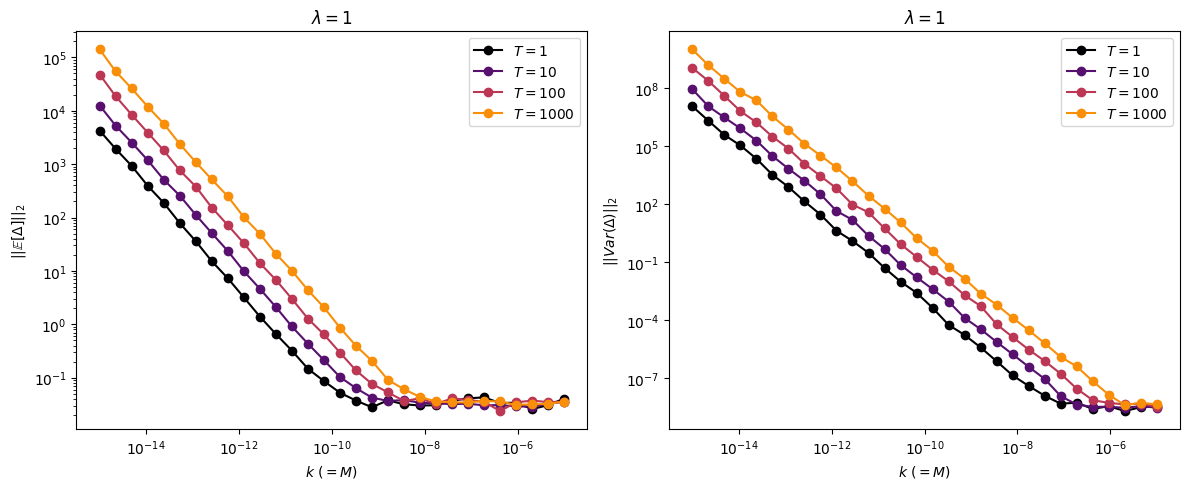

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
colors = plt.cm.winter(np.linspace(0, 1, len(friction_values)))
colors_temp = plt.cm.inferno(np.linspace(0, 1, len(temp_values) + 1))

ax = ax.flatten()

for t, temp in enumerate(temp_values):
    ax[0].plot(
        k_values,
        errors_temp[temp],
        label=rf"$T={temp}$",
        color=colors_temp[t],
        marker="o",
    )
    ax[1].plot(
        k_values,
        vars_temp[temp],
        label=rf"$T={temp}$",
        color=colors_temp[t],
        marker="o",
    )

for i in range(2):
    ax[i].set_xlabel(r"$k\ (=M)$")
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    # ax[i].grid(True)
    ax[i].legend()
    if i % 2 == 0:
        ax[i].set_ylabel(r"$||\mathbb{E}[\Delta]||_2$")
    else:
        ax[i].set_ylabel(r"$||Var(\Delta)||_2$")

    ax[i].set_title(rf"$\lambda=1$")

plt.tight_layout()
plt.savefig("figs/error_variance_T.pdf")

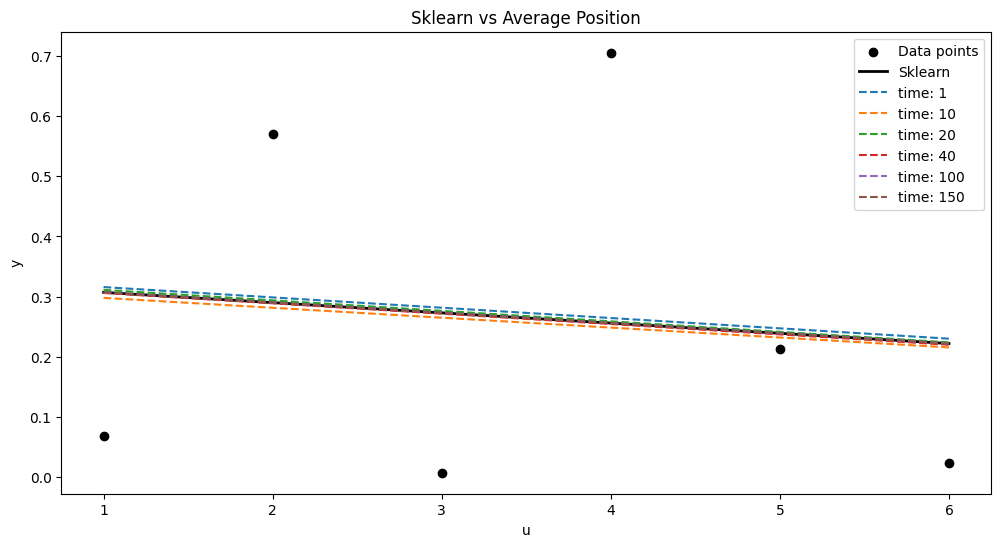

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import LinearRegression

sol = ys_ud[:, -1, :2]
linspace = np.linspace(min(u_i), max(u_i), 1000)
time_points = [1, 10, 20, 40, 100, 150]

plt.figure(figsize=(12, 6))
plt.scatter(u_i, y_i, label="Data points", c="black")

reg = LinearRegression().fit(u_i.reshape(-1, 1), y_i)
plt.plot(
    linspace,
    reg.predict(linspace.reshape(-1, 1)),
    label="Sklearn",
    c="black",
    linewidth=2,
)

# Plot average positions for specified time points
for index in time_points:
    x0_avg = torch.mean(sol[index:, 0]).detach().numpy()
    x1_avg = torch.mean(sol[index:, 1]).detach().numpy()
    plt.plot(
        linspace,
        x0_avg + (linspace - u_min) * (x1_avg - x0_avg) / ell,
        linestyle="dashed",
        label=f"time: {index}",
    )

plt.legend()
plt.xlabel("u")
plt.ylabel("y")
plt.title("Sklearn vs Average Position")
plt.show()

Text(0.5, 1.0, 'Min cost: 0.2237103283405304')

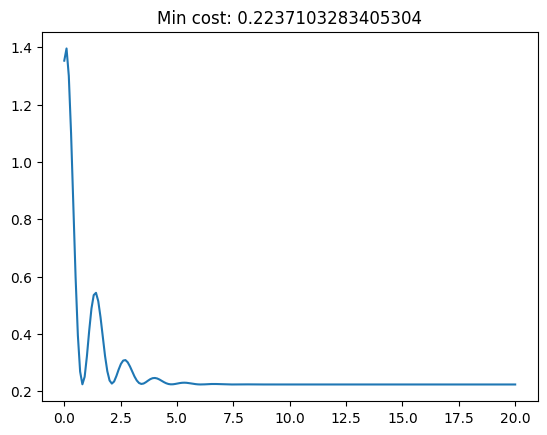

In [ ]:
plt.plot(ts, sde.cost(ys_ud[:, 0, :]))
plt.title(f"Min cost: {sde.cost(ys_ud[:,0,:]).min()}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.animation import FuncAnimation, PillowWriter
import math

from springs_plot import spring


def plot_final_frame(
    ts,
    ys,
    u_i,
    y_i,
    k,
    M,
    ell,
    path="final_frame.pdf",
    frame_skip=1,
    with_optimal=False,
):
    """Plots the final frame of the spring movement."""
    solution = np.array(ys)  # Assuming ys is already a NumPy array or similar

    # Setting up the figure
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(u_i, y_i, label="Data points", marker="x", c="black")
    linspace = np.linspace(min(u_i), max(u_i), 1000)

    # Get the final state of the solution
    q0f = solution[-1, 0]
    q1f = solution[-1, 1]

    (line,) = ax.plot(
        linspace,
        q0f + (q1f - q0f) * (linspace - q0f) / ell,
        label="Solution",
        c="black",
        linewidth=3,
    )

    # Plotting the springs
    N = len(u_i)  # Number of springs
    for i in range(N):
        x_spring, y_spring = spring(
            [u_i[i], y_i[i]],
            [u_i[i], q0f + (q1f - q0f) * (u_i[i] - q0f) / ell],
            nodes=10,
            width=0.1,
        )
        ax.add_line(mlines.Line2D(x_spring, y_spring, color="grey", linestyle="solid"))

    # Remove axis borders
    ax.axis("off")

    if with_optimal:
        reg = LinearRegression().fit(u_i.reshape(-1, 1), y_i)
        plt.plot(
            linspace,
            reg.predict(linspace.reshape(-1, 1)),
            label="Linear Regression",
            c="r",
        )

    # Save the figure
    plt.savefig(path, bbox_inches="tight", format="pdf")
    plt.close(fig)

In [ ]:
plot_final_frame(
    ts, ys_ud[:, 0, :], u_i, y_i, k, M, ell, path="final_frame.pdf", with_optimal=True
)

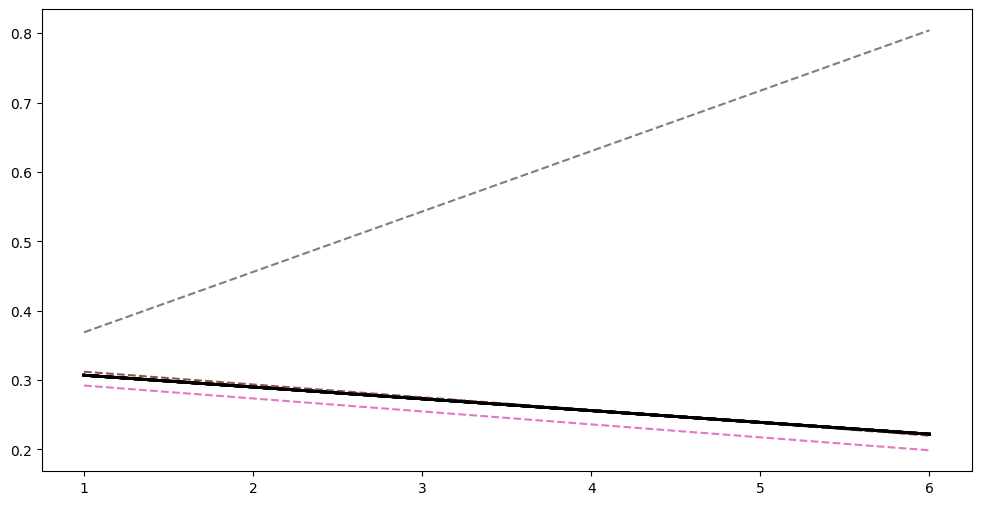

In [ ]:
import numpy as np
import torch
import torchsde
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Assuming S3DE is defined elsewhere and properly imports torchsde

# Define your parameters
batch_size, state_size, t_size = 2, 4, 200
ts = torch.linspace(0, 20, t_size)
y0 = torch.rand(size=(batch_size, state_size))
ell = max(u_i) - min(u_i)

# k and M values, assuming k = M for simplification
P_values = [1e-10, 1e-12, 1e-14, 1e-16, 1e-18, 1e-20, 1e-22, 1e-24]

# Placeholder for error values
errors = []
vars = []

fig, ax = plt.subplots(figsize=(12, 6))

for P in P_values:
    # Solve the SDE
    sde = S3DE(1, k=P, M=P, temp=1)
    with torch.no_grad():
        ys_ud = torchsde.sdeint(sde, y0, ts, method="euler")

    # Compute my_coef and intercept

    # get average xi and xf
    sol = ys_ud[:, -1, :2]
    xi = x0_avg = torch.mean(sol[t_size // 2 :, 0]).detach().numpy()
    xf = x1_avg = torch.mean(sol[t_size // 2 :, 1]).detach().numpy()

    my_coef = (xf - xi) / ell
    intercept = xi - my_coef * 1

    # Assuming u_i and y_i are your data arrays for linear regression
    reg = LinearRegression().fit(u_i.reshape(-1, 1), y_i)
    error = np.sqrt((my_coef - reg.coef_) ** 2 + (intercept - reg.intercept_) ** 2)
    errors.append(error.item())

    est_m = (sol[t_size // 2 :, 1] - sol[t_size // 2 :, 0]) / ell
    est_intercept = sol[t_size // 2 :, 0] - est_m

    delta2m = torch.mean((est_m - reg.coef_) ** 2).detach().numpy()
    delta2c = torch.mean((est_intercept - reg.intercept_) ** 2).detach().numpy()

    deltam = torch.mean(est_m - reg.coef_).detach().numpy()
    deltac = torch.mean(est_intercept - reg.intercept_).detach().numpy()

    var = np.sqrt((delta2m - deltam**2) ** 2 + (delta2c - deltac**2) ** 2)
    vars.append(var)

    ax.plot(
        linspace,
        reg.predict(linspace.reshape(-1, 1)),
        label="Sklearn",
        c="black",
        linewidth=2,
    )

    # Plot average positions for specified time points
    ax.plot(
        linspace,
        x0_avg + (linspace - u_min) * (x1_avg - x0_avg) / ell,
        linestyle="dashed",
        label=rf"$M=k={P}$",
    )

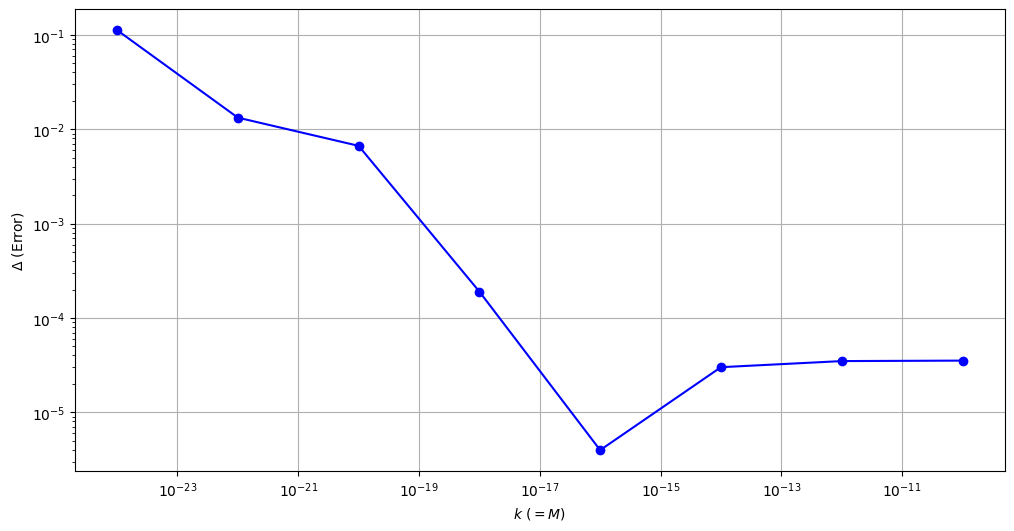

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
# plt.errorbar(P_values, errors,yerr=np.sqrt(vars), marker='o', linestyle='-', color='blue')
plt.plot(P_values, errors, marker="o", linestyle="-", color="blue")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$k\ (=M)$")
plt.ylabel(r"$\Delta$ (Error)")
# plt.title('Error vs. $k\ (=M)$')
plt.grid(True)
plt.show()

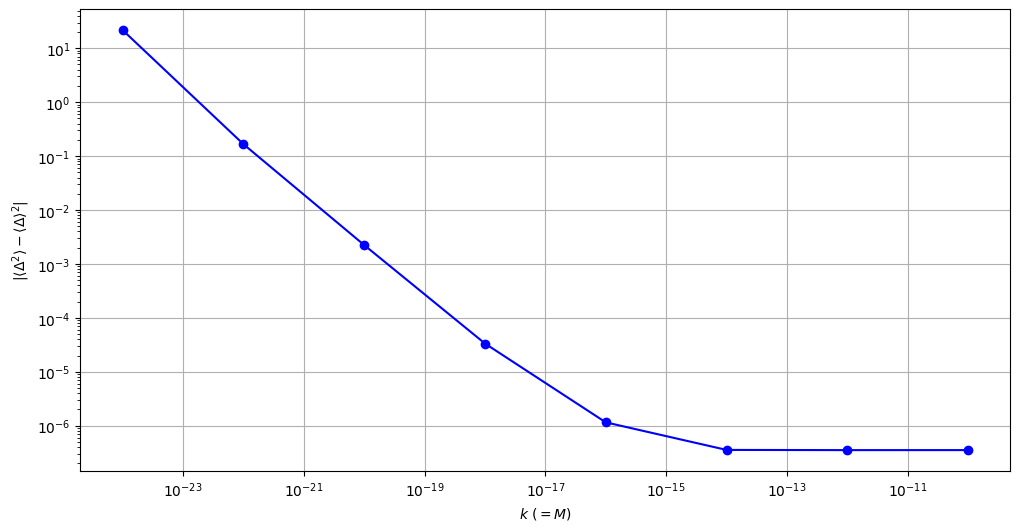

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(P_values, vars, marker="o", linestyle="-", color="blue")
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$k\ (=M)$")
plt.ylabel(r"$|\langle {\Delta}^2 \rangle - \langle {\Delta} \rangle^2 |$")
plt.grid(True)
plt.show()

## Entropy production

The training of an ML model is an irriversible process. This process begins with a random distribution of parameters $\theta$ and evolves to an optimal set of parameters $\theta_\star$ (or a small distribution near it), thus decreasing the entropy of the system. Given that our physical system is described by a linear Langevin, we can use [this result](https://arxiv.org/abs/1507.00232), to easily compute the entropy production as a function of time.

In [ ]:
batch_size, state_size, t_size = 1000, 4, 200
ts = torch.linspace(0, 30, t_size)

In [ ]:
def get_xxt_avg(ys):
    yse = ys[:, :, :, None]
    yse_t = yse.transpose(2, 3)

    xxt = torch.matmul(yse, yse_t)
    xxt_avg = torch.mean(xxt, dim=1)
    return xxt_avg


def get_x_avg(ys):
    return torch.mean(ys, dim=1)


def get_theta(ys):
    xxt_avg = get_xxt_avg(ys)
    x_avg_e = get_x_avg(ys)[:, :, None]
    x_avg_t = x_avg_e.transpose(1, 2)
    return xxt_avg - torch.matmul(x_avg_e, x_avg_t)


def get_Dtensor(diag):
    diag = diag.type(dtype=torch.float64)
    diag_tensor = torch.diag(diag)
    Dtensor = diag_tensor @ diag_tensor.T / 2
    return Dtensor


def get_A_Airr_Arev(ktilde, ltilde, gammas):
    Airr = torch.zeros(4, 4, dtype=torch.float64)
    Airr[2, 2] = ltilde
    Airr[3, 3] = ltilde

    A = torch.zeros(4, 4, dtype=torch.float64)
    A[0, 2] = 1
    A[1, 3] = 1
    A[2, 2] = ltilde
    A[3, 3] = ltilde
    A[2, 0] = -ktilde * np.sum(gammas * (1 + gammas))
    A[3, 0] = ktilde * np.sum(gammas * (1 + gammas))
    A[2, 1] = ktilde * np.sum(gammas * gammas)
    A[3, 1] = -ktilde * np.sum(gammas * gammas)

    Arev = A - Airr

    return A, Airr, Arev


def first_term(theta, Dtensor, Airr):
    theta_inv = torch.linalg.pinv(theta).type(dtype=torch.float64)
    DTinv = torch.matmul(Dtensor, theta_inv)
    tr1 = np.trace(DTinv - Airr, axis1=1, axis2=2)
    return tr1


def second_term(theta, Dtensor, Airr, Dtensor_inv):
    airrtdinv = torch.matmul(Airr.T, Dtensor_inv)
    airrtheta = torch.matmul(Airr.T, theta)
    AiTDinvAiT = torch.matmul(airrtdinv, airrtheta)
    tr2 = np.trace(AiTDinvAiT - Airr, axis1=1, axis2=2).flatten()
    return tr2


def third_term(theta, Dtensor, Airr, Dtensor_inv, x_avg):
    AiX = torch.matmul(Airr, x_avg[:, :, None])
    tr3 = (
        torch.matmul(torch.matmul(AiX.transpose(1, 2), Dtensor_inv[None, :, :]), AiX)
        .flatten()
        .numpy()
    )
    return tr3


def get_entropy_production_rate(ys, sde):
    theta = get_theta(ys).type(torch.float64)
    x_avg = get_x_avg(ys).type(dtype=torch.float64)

    ktilde = 6 * sde.k / sde.M
    ltilde = sde.friction / sde.M
    gammas = (u_i[0] - u_i) / sde.ell

    # Dtensor = get_Dtensor(torch.tensor([0, 0, sde.eta_cte, sde.eta_cte]))
    Dtensor = get_Dtensor(torch.ones(4) * sde.eta_cte)
    A, Airr, Arev = get_A_Airr_Arev(ktilde, ltilde, gammas)

    theta_avg = torch.mean(theta[-50:, :, :], dim=0)

    # This is dTheta/dt, if close to 0 means that the system reached a steady state
    print(torch.max(A @ theta_avg + theta_avg @ (A.T) - 2 * Dtensor))

    Dtensor_inv = torch.linalg.pinv(Dtensor).type(dtype=torch.float64)

    tr1 = first_term(theta, Dtensor, Airr)
    tr2 = second_term(theta, Dtensor, Airr, Dtensor_inv)
    tr3 = third_term(theta, Dtensor, Airr, Dtensor_inv, x_avg)

    Pit = tr1 + tr2 + tr3

    return Pit

tensor(0.2313, dtype=torch.float64)


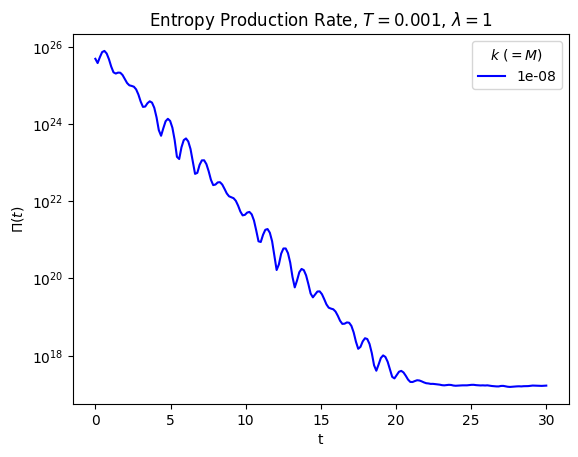

In [ ]:
# K_values = M_values= np.logspace(-4, -20, num=5, base=10)
K_values = M_values = [1e-7, 1e-8, 1e-9, 1e-10, 1e-11]

colors = plt.cm.winter(np.linspace(0, 1, len(K_values)))

ys_dic = {}
pit_dic = {}

for i, (k, M) in enumerate(zip(K_values, M_values)):
    sde = S3DE(u_i, y_i, friction=1, temp=0.001, k=k, M=M)

    y0 = torch.rand(size=(batch_size, state_size))

    with torch.no_grad():
        ys = torchsde.sdeint(sde, y0, ts, method="euler")

    Pit = get_entropy_production_rate(ys, sde)

    ys_dic[k] = ys
    pit_dic[k] = Pit

    plt.plot(ts, Pit, label=format(M, ".0e"), color=colors[i])

plt.title(f"Entropy Production Rate, $T={sde.temp}$, $\lambda={sde.friction}$")
plt.xlabel("t")
plt.yscale("log")
plt.ylabel("$\Pi(t)$")
plt.legend(title=r"$k\ (=M)$")
plt.savefig("figs/entropy_production.pdf")
plt.show()

In [ ]:
# get entropy of first
ys.shape  # time, batch, state

torch.Size([200, 1000, 4])

In [ ]:
final_p = ys[-1, :, :2]
final_p.shape

torch.Size([1000, 2])

In [ ]:
init_p = ys[0, :, :2]
init_p.shape

torch.Size([1000, 2])

In [ ]:
from scipy.stats import entropy

In [ ]:
hist_init, bin_edges_init = np.histogram(
    init_p[:, 0].numpy(), bins="auto", density=True
)
init_probs = hist_init * np.diff(bin_edges_init)
s_init = entropy(init_probs, base=2)

In [ ]:
hist_final, bin_edges_final = np.histogram(
    final_p[:, 0].numpy(), bins="auto", density=True
)
final_probs = hist_final * np.diff(bin_edges_final)
s_final = entropy(final_probs, base=2)

In [ ]:
final_p[:, 0].numpy().max() - final_p[:, 0].numpy().min()

8.3863735e-05

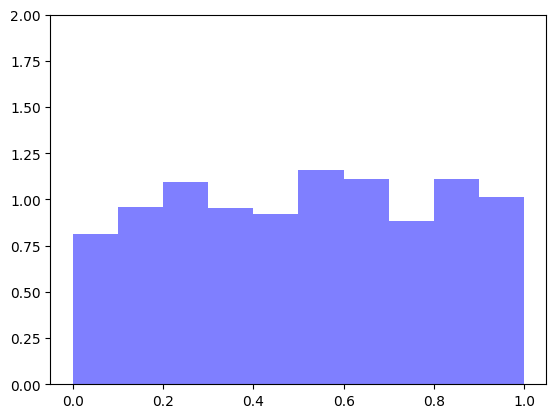

In [ ]:
# plot histograms
plt.figure()
plt.hist(init_p[:, 0], bins=10, density=True, alpha=0.5, label="Initial", color="blue")
plt.hist(final_p[:, 0], bins=10, density=True, alpha=0.5, label="Final", color="red")
plt.ylim(0, 2)
plt.show()

In [ ]:
init_p[:, 0].max(), init_p[:, 0].min()

(tensor(0.9989), tensor(0.0007))

In [ ]:
final_p[:, 0].max(), final_p[:, 0].min()

(tensor(0.5489), tensor(0.5488))

### Entropy flux

In [ ]:
Phit = (tr2 + tr3) * kb * sde.temp

NameError: name 'tr2' is not defined

In [ ]:
plt.plot(ts, Phit)
plt.title("Entropy Flux $\Phi(t)$")
plt.xlabel("t")
plt.yscale("log")
plt.ylabel("$k_b T \Phi(t)$")

In [ ]:
dSdt = tr1 * kb * sde.temp

In [ ]:
plt.plot(ts, dSdt)
plt.title("$dS/dt $")
plt.xlabel("t")
plt.yscale("log")
plt.ylabel("$k_b T dS/dt$", loc="top")

### Decomposition of $\Pi$

In [ ]:
Pi0 = Phit[-1]

In [ ]:
Pi1 = np.trace(DTinv - A, axis1=1, axis2=2)
Pi1 += np.trace(A @ theta_inv[-1, :, :] @ theta - A, axis1=1, axis2=2)
Pi1 += (
    (
        (x_avg - x_avg[-1, :])[:, None, :]
        @ theta_inv[-1, :, :]
        @ Dtensor
        @ theta_inv[-1, :, :]
        @ ((x_avg - x_avg[-1, :])[:, :, None])
    )
    .flatten()
    .numpy()
)

In [ ]:
(x_avg - x_avg[-1, :]).T.shape

In [ ]:
np.min(np.trace(A @ theta_inv[0, :, :] @ theta - A, axis1=1, axis2=2))

In [ ]:
plt.plot(ts, Pi1)
plt.title("$XXX $")
plt.xlabel("t")
plt.yscale("log")
plt.ylabel("$k_b T$", loc="top")

In [ ]:
evolution_plot(
    ts, torch.hstack([ys_ud[:, 0, :2][:, :, None]]), xlabel="$t$", ylabel="$x_i$"
)

In [ ]:
Dtensor_inv[None, :, :].shape